In [88]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [89]:
# Baixar dados
ticker = "VALE"  # Exemplo: Apple
data = yf.download(ticker, start="2010-01-01", end="2024-11-23")
data = data[['Close']]  # Usar somente o preço de fechamento
data.rename(columns={'Close': 'price'}, inplace=True)

# Visualizar os dados
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price           price
Ticker           VALE
Date                 
2010-01-04  30.250000
2010-01-05  30.570000
2010-01-06  31.059999
2010-01-07  31.150000
2010-01-08  31.480000


In [104]:
# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
data['normalized_price'] = scaler.fit_transform(data[['price']])

# Criar sequências de treino
def create_sequences(data, lookback, future_steps=[1, 2, 5, 15]):
    sequences, targets = [], []
    for i in range(len(data) - lookback - max(future_steps)):
        seq = data[i:i + lookback]
        target = [data[i + lookback + step] for step in future_steps]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

lookback = 365
future_steps = [1, 2, 5, 15]
sequences, targets = create_sequences(data['normalized_price'].values, lookback, future_steps)

# Dividir em treino e teste
train_size = int(len(sequences) * 0.8)
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = targets[:train_size], targets[train_size:]

print("Forma de X_train:", X_train.shape)  # (n_samples, lookback)
print("Forma de y_train:", y_train.shape)  # (n_samples, n_steps)

Forma de X_train: (2695, 365)
Forma de y_train: (2695, 4)


In [105]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Pegar apenas a última saída
        last_output = lstm_out[:, -1, :]  # Último passo de tempo
        # Aplicar dropout na última saída
        last_output = self.dropout(last_output)
        # Passar pela camada final
        output = self.fc(last_output)
        return output

# Configurações do modelo
input_size = 1  # Preço normalizado
hidden_size = 50
output_size = len(future_steps)
num_layers = 2
model = LSTMModel(input_size, hidden_size, output_size)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [106]:
# Configuração de treinamento
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Conversão para tensores
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)  # (n_samples, lookback, input_size)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
y_test_tensor = torch.FloatTensor(y_test)

# Treinamento
epochs = 70
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Época [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Época [10/70], Loss: 0.0894
Época [20/70], Loss: 0.0336
Época [30/70], Loss: 0.0236
Época [40/70], Loss: 0.0231
Época [50/70], Loss: 0.0200
Época [60/70], Loss: 0.0172
Época [70/70], Loss: 0.0134


Loss no conjunto de teste: 0.0021


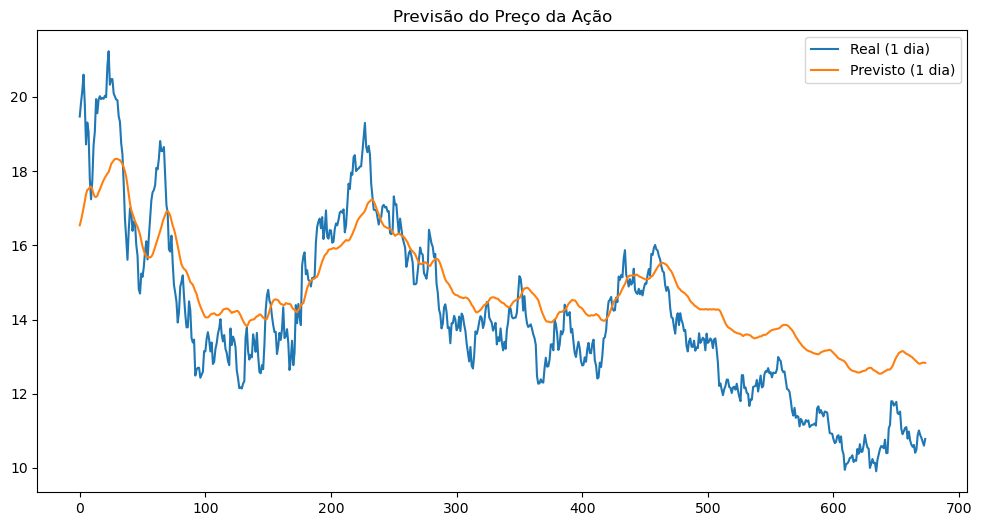

In [107]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    loss = criterion(predictions, y_test_tensor)
    print(f"Loss no conjunto de teste: {loss.item():.4f}")

# Reverter a normalização para os valores reais
predictions = scaler.inverse_transform(predictions.numpy())
y_test_real = scaler.inverse_transform(y_test)

# Comparar valores reais e previstos
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_real[:, 0], label="Real (1 dia)")
plt.plot(predictions[:, 0], label="Previsto (1 dia)")
plt.title("Previsão do Preço da Ação")
plt.legend()
plt.show()

In [108]:
# Avaliar o modelo
model.eval()  # Modo de avaliação
with torch.no_grad():
    predictions = model(X_test_tensor)  # Previsões no conjunto de teste

# Reverter normalização das previsões e dos valores reais
predictions_real = scaler.inverse_transform(predictions.numpy())
y_test_real = scaler.inverse_transform(y_test)

# Calcular métricas
def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula o erro percentual absoluto médio (MAPE)."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAE
mae = mean_absolute_error(y_test_real, predictions_real)

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_real, predictions_real))

# MAPE
mape = mean_absolute_percentage_error(y_test_real, predictions_real)

# Exibir resultados
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 1.32
Root Mean Square Error (RMSE): 1.62
Mean Absolute Percentage Error (MAPE): 9.93%
